<a href="https://colab.research.google.com/github/Cal-Poly-Data-301/lab-5-DylanC3/blob/main/DATA_301_Lab_5_Dylan_Cho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authorship of the Federalist Papers

The _Federalist Papers_ were a set of 85 essays published between 1787 and 1788 to promote the ratification of the United States Constitution. They were originally published under the pseudonym "Publius". Although the identity of the authors was a closely guarded secret at the time, most of the papers have since been conclusively attributed to one of Hamilton, Jay, or Madison. The known authorships can be found in `https://dlsun.github.io/pods/data/federalist/authorship.csv`.

For 15 of the papers, however, the authorships remain disputed. (These papers can be identified from the `authorship.csv` file because the "Author" field is blank.) In this analysis, you will use the papers with known authorship to predict the authorships of the disputed papers. The text of each paper is available at `https://dlsun.github.io/pods/data/federalist/x.txt`, where `x` is the number of the paper (i.e., a number from 1 to 85). The name of the file indicates the number of the paper.

In [ ]:
import pandas as pd

df_fed = pd.read_csv("https://dlsun.github.io/pods/data/federalist/authorship.csv") 
df_fed["Author"] = df_fed["Author"].fillna("NA")

## Question 1

When analyzing an author's style, common words like "the" and "on" are actually more useful than rare words like "hostilities". That is because rare words typically signify context. Context is useful if you are trying to find documents about similar topics, but not so useful if you are trying to identify an author's style because different authors can write about the same topic. For example, both Dr. Seuss and Charles Dickens used rare words like "chimney" and "stockings" in _How the Grinch Stole Christmas_ and _A Christmas Carol_, respectively. But they used common words very differently: Dickens used the word "upon" over 100 times, while Dr. Seuss did not use "upon" even once.

Read in the Federalist Papers. Convert each one into a vector of term frequencies. In order to restrict to common words, include only the top 50 words across the corpus. (Because we are restricting to the most common words already, there is no reason to reweight them using TF-IDF.)

In [ ]:
import requests
texts = pd.Series()

for index in df_fed["Paper"]:
  response = requests.get("https://dlsun.github.io/pods/data/federalist/" + str(index) + ".txt", "r")
  texts[str(df_fed[df_fed.Paper == index])] = response.text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer() # can adjust token_pattern to include single letter words
vec.fit(texts)
tf_sparse = vec.transform(texts)

df_tf = pd.DataFrame(tf_sparse.todense(),
                     columns=vec.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df_tf.sum(axis=0).sort_values(ascending=False).head(50) # top 50 words across corpus

the             17767
of              11824
to               7074
and              5099
in               4456
be               3825
that             2792
it               2550
is               2194
which            2068
by               1741
as               1721
this             1410
would            1273
have             1262
will             1255
for              1237
or               1233
not              1215
their            1098
with             1053
from             1043
are              1032
on                952
they              928
an                927
states            851
government        829
may               816
been              798
state             787
all               731
but               697
its               651
other             646
people            612
power             603
has               603
more              579
at                568
if                563
than              550
them              548
one               547
any               545
no        

## Question 2
Make a visualization that summarizes the most common words used by Hamilton, Madison, and Jay.

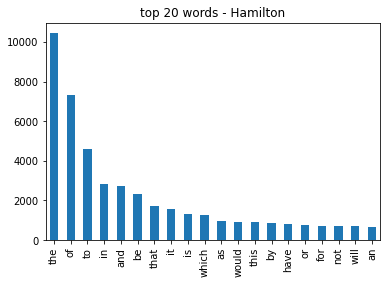

In [ ]:
indices = []
for index in df_fed[df_fed.Author == "Hamilton"].Paper:
  indices.append(index - 1) # index is 1 less than Paper number

df_tf.loc[indices].sum(axis=0).sort_values(ascending=False).head(20).plot.bar(title="top 20 words - Hamilton") # top 20 visualization

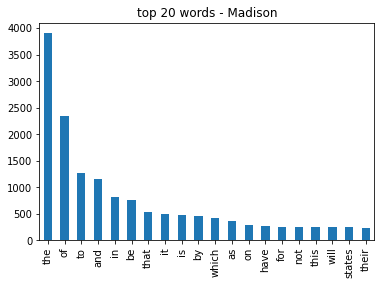

In [ ]:
indices = []
for index in df_fed[df_fed.Author == "Madison"].Paper:
  indices.append(index - 1) # index is 1 less than Paper number

df_tf.loc[indices].sum(axis=0).sort_values(ascending=False).head(20).plot.bar(title="top 20 words - Madison") # top 20 visualization

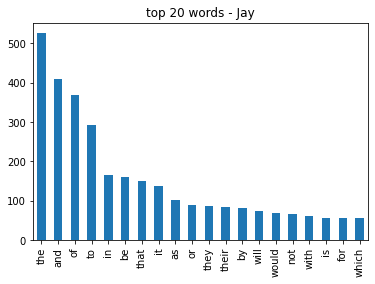

In [ ]:
indices = []
for index in df_fed[df_fed.Author == "Jay"].Paper:
  indices.append(index - 1) # index is 1 less than Paper number

df_tf.loc[indices].sum(axis=0).sort_values(ascending=False).head(20).plot.bar(title="top 20 words - Jay") # top 20 visualization

## Question 3

For each of the documents with disputed authorships, find the 5 most similar documents with _known_ authorships, using cosine distance on the term frequencies. Use the authors of these 5 most similar documents to predict the author of each disputed document. (For example, if 3 of the 5 closest documents were written by Hamilton, 1 by Madison, and 1 by Jay, then we would predict that the disputed document was written by Hamilton.)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import numpy as np

unknown = df_fed[df_fed["Author"] == "NA"]["Paper"].unique()
unknown

array([18, 19, 20, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 62, 63])

In [ ]:
essay_predictions = []

for i in range(len(unknown)):
  distances = cosine_similarity(tf_sparse)[unknown[i] - 1]
  closest = pd.DataFrame(distances, columns = ["Distances"])
  closest["Paper"] = df_fed["Paper"]
  closest["Author"] = df_fed["Author"]

  closest_known = closest[closest.Author != "NA"]
  essay_predictions.append(closest_known.sort_values(by=["Distances"], ascending=False)["Author"].iloc[0:5].value_counts().idxmax())

In [ ]:
essay_prediction_df = pd.DataFrame()
essay_prediction_df["Essays"] = unknown
essay_prediction_df["Predictions"] = essay_predictions
essay_prediction_df

,Essays,Predictions
0,18,Madison
1,19,Hamilton
2,20,Madison
3,49,Madison
4,50,Madison
5,51,Madison
6,52,Madison
7,53,Madison
8,54,Hamilton
9,55,Hamilton


## Submission Instructions

- Copy this notebook to your own Drive, if you have not already.
- Restart this notebook and run the cells from beginning to end. 
  - Go to Runtime > Restart and Run All.
- Rename this notebook by clicking on "DATA 301 Lab 5 - YOUR NAMES HERE" at the very top of this page. Replace "YOUR NAMES HERE" with the first and last names of you (and your partners, for Phase 2).
- Get the link to your notebook:
  - Click on "Share" at the top-right. 
  - Change the settings to "Anyone with the link can view". 
  - Copy the sharing link into Canvas.